# Clustering

## 1. Libraries

In [50]:
import pandas as pd
import matplotlib.pyplot as plt

## 2. Reading data

In [51]:
df = pd.read_parquet('cleaned_data/df_combined.parquet')
df_filtered = pd.read_pickle('cleaned_data/df_filtered.pkl')

### CLUSTERING
#### 1. TF-IDF VECTORIZATION 
Applying tf-idf vectorization

In [52]:
from sklearn.feature_extraction.text import TfidfVectorizer

vectorizer = TfidfVectorizer(sublinear_tf=True, min_df=5, max_df=0.95)
X = vectorizer.fit_transform(df_filtered['text_clean_en_demojized']).toarray()
X = vectorizer.fit_transform(df_filtered['text_clean_en_demojized']).toarray()

#### 2. Sentence transformer

Applying Sentence transformer vectorization

In [53]:
from sentence_transformers import SentenceTransformer
import numpy as np
import time

st = time.time()

model = SentenceTransformer('paraphrase-MiniLM-L6-v2')
df_filtered['encode_transforemers'] = df_filtered['text_clean_en_demojized'].apply(lambda text: model.encode(text, convert_to_numpy=True).flatten())

et = time.time()

print("Elapsed time: {:.2f} seconds".format(et - st))

X_transformers = np.vstack(df_filtered['encode_transforemers'])


Elapsed time: 298.40 seconds


#### Bert CLS model

Applying Bert CLS vectorization

In [54]:
from transformers import BertTokenizer, BertModel
import torch
import time

tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
model = BertModel.from_pretrained('bert-base-uncased')

def get_cls_sentence(sentence):
    input_ids = torch.tensor([tokenizer.encode(sentence, add_special_tokens=True, max_length=512)])

    with torch.no_grad():
        outputs = model(input_ids)
        cls_embedding = outputs[0][:, 0, :]
    
    return cls_embedding.flatten()

st = time.time()

df_filtered['cls_bert'] = df_filtered['text_clean_en_demojized'].apply(lambda sentence: get_cls_sentence(sentence))

et = time.time()

print("Elapsed time: {:.2f} seconds".format(et - st))

Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.


Elapsed time: 376.85 seconds


In [32]:
X_cls_bert = np.vstack(df_filtered['cls_bert'])

#### K-means clustering

Creating 2 clusters of tweets to check correlation between clusters and parties belonging (or not) to ruling majority. Firstly, with k-means algorithm.

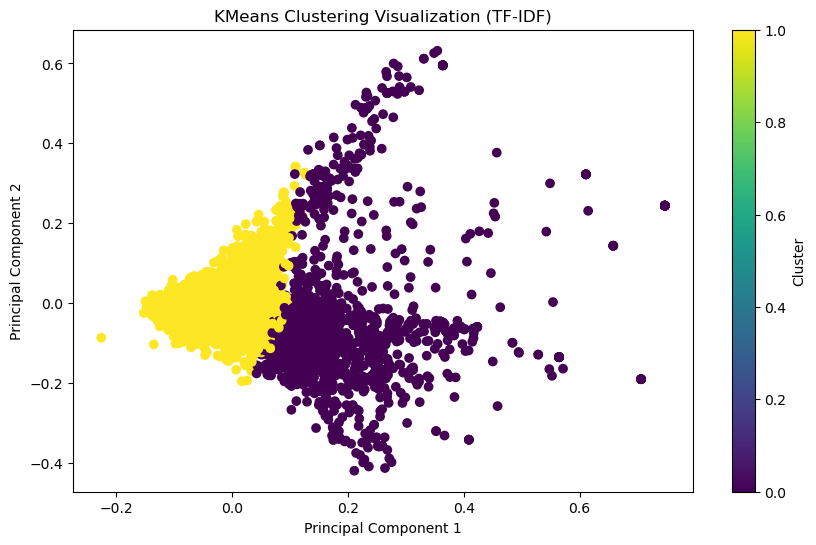

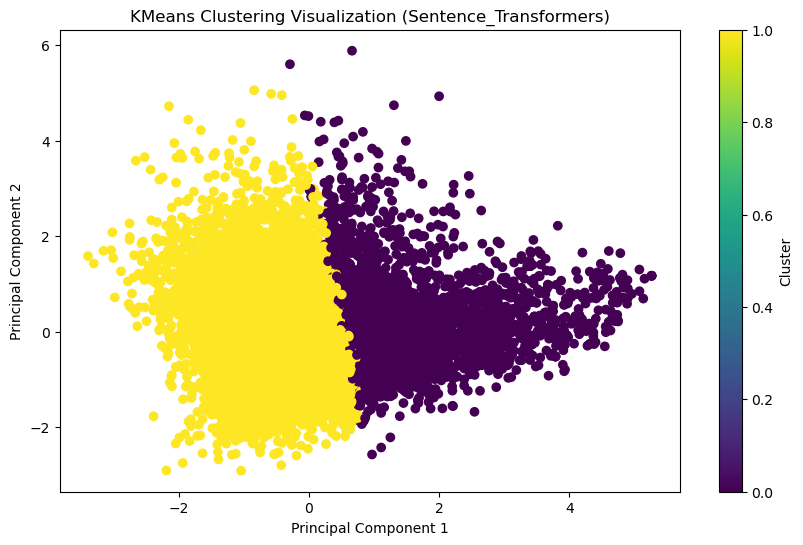

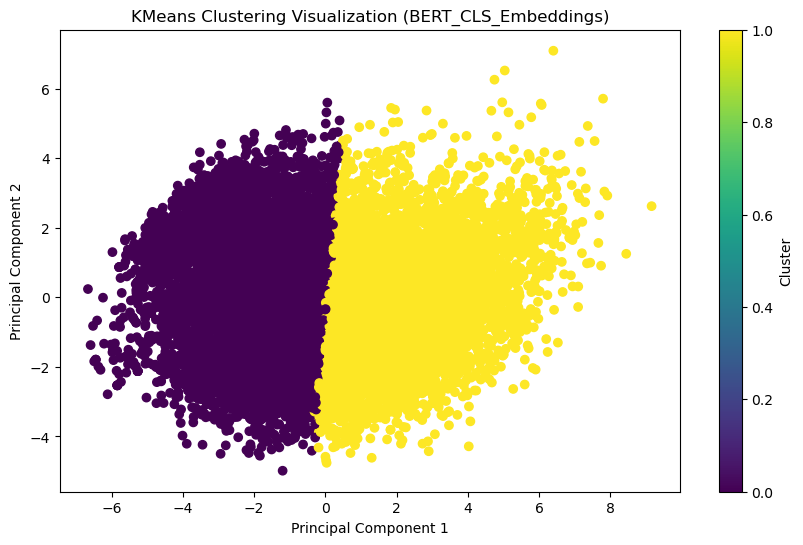

In [55]:
from sklearn.decomposition import PCA

import matplotlib.pyplot as plt

def kmeans_clustering_and_visualization(data, num_clusters=2, title=''):
    kmeans = KMeans(n_clusters=num_clusters, random_state=42)
    clusters = kmeans.fit_predict(data)
    df_filtered.loc[:, f'cluster_knn{title}'] = clusters
    pca = PCA(n_components=2)
    principal_components = pca.fit_transform(data)
    
    plt.figure(figsize=(10, 6))
    plt.scatter(principal_components[:, 0], principal_components[:, 1], c=clusters, cmap='viridis', marker='o')
    plt.title(f'KMeans Clustering Visualization ({title})')
    plt.xlabel('Principal Component 1')
    plt.ylabel('Principal Component 2')
    plt.colorbar(label='Cluster')
    plt.show()

kmeans_clustering_and_visualization(X, num_clusters=2, title='TF-IDF')

kmeans_clustering_and_visualization(X_transformers, num_clusters=2, title='Sentence_Transformers')

kmeans_clustering_and_visualization(X_cls_bert, num_clusters=2, title='BERT_CLS_Embeddings')

#### Gausian Mixture Model clustering

Creating two clusters of tweets with a GMM model.

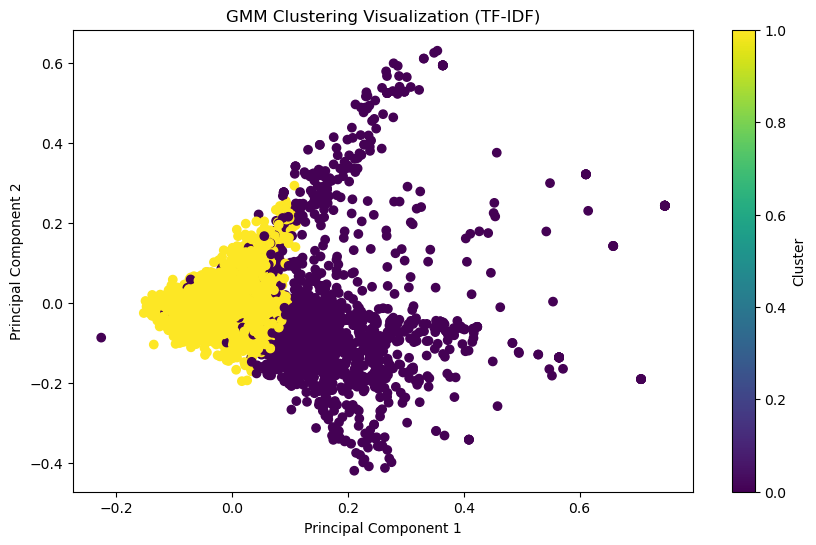

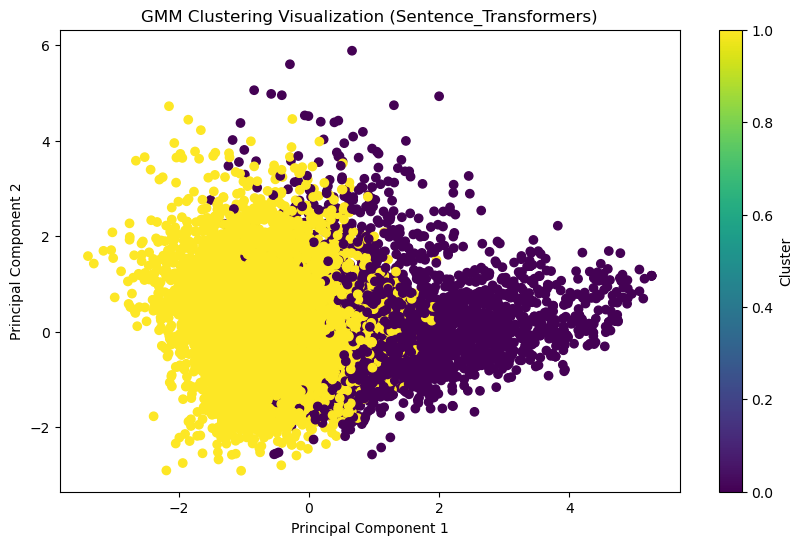

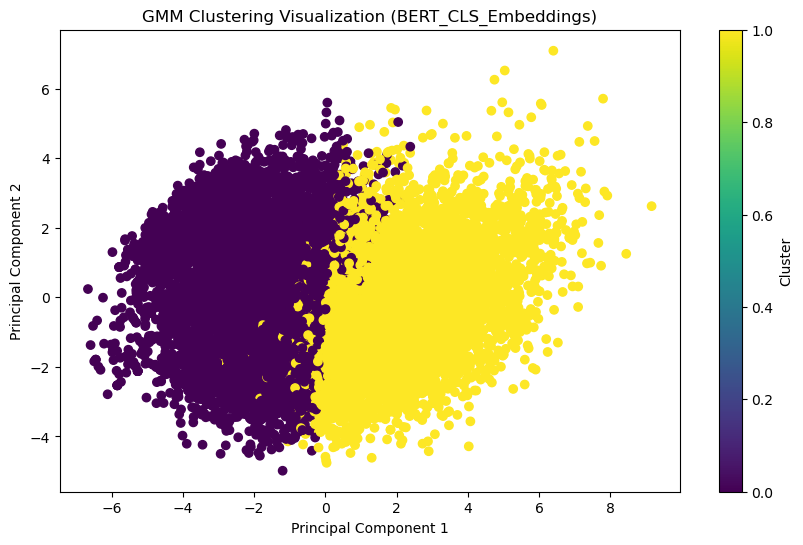

In [56]:
from sklearn.mixture import GaussianMixture

def gmm_clustering_and_visualization(data, num_clusters=2, title=''):
    gmm = GaussianMixture(n_components=num_clusters, random_state=42)
    clusters = gmm.fit_predict(data)
    df_filtered.loc[:, f'cluster_gmm_{title}'] = clusters
    pca = PCA(n_components=2)
    principal_components = pca.fit_transform(data)
    
    plt.figure(figsize=(10, 6))
    plt.scatter(principal_components[:, 0], principal_components[:, 1], c=clusters, cmap='viridis', marker='o')
    plt.title(f'GMM Clustering Visualization ({title})')
    plt.xlabel('Principal Component 1')
    plt.ylabel('Principal Component 2')
    plt.colorbar(label='Cluster')
    plt.show()

gmm_clustering_and_visualization(X, num_clusters=2, title='TF-IDF')

gmm_clustering_and_visualization(X_transformers, num_clusters=2, title='Sentence_Transformers')

gmm_clustering_and_visualization(X_cls_bert, num_clusters=2, title='BERT_CLS_Embeddings')

#### Correlation between clusters and being an opposition/proposition party - knn

In [48]:
# Create a new column 'opposition_proposition' where 1 indicates opposition and 0 indicates proposition
df_filtered['opposition_proposition'] = df_filtered['party'].apply(lambda x: 1 if x in ['Konfa', 'PIS'] else 0)

# Calculate the correlation between 'opposition_proposition' and 'cluster'
correlation = df_filtered['opposition_proposition'].corr(df_filtered['cluster_knnTF-IDF'])
correlation1 = df_filtered['opposition_proposition'].corr(df_filtered['cluster_knnSentence_Transformers'])
correlation2 = df_filtered['opposition_proposition'].corr(df_filtered['cluster_knnBERT_CLS_Embeddings'])

print(f"Correlation between clusters (knn) and opposition/proposition (TF-IDF): {correlation}")
print(f"Correlation between clusters (knn) and opposition/proposition (Sentence Transformes): {correlation1}")
print(f"Correlation between clusters (knn) and opposition/proposition (BERT CLS Embeddings): {correlation2}")

Correlation between clusters (knn) and opposition/proposition (TF-IDF): 0.10719163253634034
Correlation between clusters (knn) and opposition/proposition (Sentence Transformes): 0.14171358487060043
Correlation between clusters (knn) and opposition/proposition (BERT CLS Embeddings): 0.08410093145724994


#### Correlation between clusters and being an opposition/proposition party - gmm

In [57]:
df_filtered.loc[:, 'opposition_proposition'] = df_filtered['party'].apply(lambda x: 1 if x in ['Konfa', 'PIS'] else 0)

# Calculate the correlation between 'opposition_proposition' and 'cluster'
correlation_gmm_tf_idf = df_filtered['opposition_proposition'].corr(df_filtered['cluster_gmm_TF-IDF'])
correlation_gmm_sentence_transformers = df_filtered['opposition_proposition'].corr(df_filtered['cluster_gmm_Sentence_Transformers'])
correlation_gmm_bert_cls_embeddings = df_filtered['opposition_proposition'].corr(df_filtered['cluster_gmm_BERT_CLS_Embeddings'])

print(f"Correlation between GMM clusters and opposition/proposition (TF-IDF): {correlation_gmm_tf_idf}")
print(f"Correlation between GMM clusters and opposition/proposition (Sentence Transformers): {correlation_gmm_sentence_transformers}")
print(f"Correlation between GMM clusters and opposition/proposition (BERT CLS Embeddings): {correlation_gmm_bert_cls_embeddings}")

Correlation between GMM clusters and opposition/proposition (TF-IDF): 0.11350053170265925
Correlation between GMM clusters and opposition/proposition (Sentence Transformers): 0.1331334006595999
Correlation between GMM clusters and opposition/proposition (BERT CLS Embeddings): 0.09284472269510827


The correlation values are not high. The highest correlation value has been obtained using k-means clustering with sentence transformer vectorization.

In [43]:
df_filtered.to_pickle('cleaned_data/df_filtered.pkl')